<a href="https://colab.research.google.com/github/virbickt/default-risk-prediction/blob/main/modeling_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelling

Before we proceed with the modelling part, let us bring all the preprocessing steps together in a function that serves as a data preprocessing pipeline (for we were unable to use the actual `sklearn.pipeline.Pipeline` because of the requirements for the components to implement `fit()` and `transform()`).

In [ ]:
# load the version of data that comes after merging the tables
WORKING_train = pd.read_csv("/content/drive/MyDrive/341/UPDATED_full_train.csv")
WORKING_test = pd.read_csv("/content/drive/MyDrive/341/UPDATED_full_test.csv")
WORKING_y = pd.read_csv("/content/drive/MyDrive/341/WORKING_y.csv")
WORKING_y = WORKING_y.iloc[:, 1]

In [ ]:
WORKING_train.shape, WORKING_test.shape

((307511, 212), (48744, 212))

In [ ]:
def processing_pipeline(
    train: pd.DataFrame, test: pd.DataFrame, y: pd.Series
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series]:
    """
    Applies all the preprocessing steps previously discussed in the notebook to both train and set sets in their original state.

    :param train: dataframe that is be used as a train set, unprocessed
    :param test: dataframe that is to be used as a test set, unprocessed

    :return train_processed: dataframe to be used as a train set which had all the preprocessing steps applied to it
    :return test_processed: dataframe to be used as a test set which had all the preprocessing steps applied to it
    :return y: series with the values of the target variable. No processing has been applied to it so its returned in its original form.
    """

    # make two copies:
    train_processed = train.copy()
    test_processed = test.copy()
    x_modeling = train.copy()

    # extract the predictors and leave out the id and the target so they are not treated as other numerical features
    # train_processed = train_processed.iloc[:, 2:]

    # initialize the list with AMT_REQ_CREDIT_BUREAU variables to have them preprocessed separately
    amt_req_credit_bureau = [
        "AMT_REQ_CREDIT_BUREAU_YEAR",
        "AMT_REQ_CREDIT_BUREAU_QRT",
        "AMT_REQ_CREDIT_BUREAU_MON",
        "AMT_REQ_CREDIT_BUREAU_WEEK",
        "AMT_REQ_CREDIT_BUREAU_DAY",
        "AMT_REQ_CREDIT_BUREAU_HOUR",
    ]

    # initialize the list with housing-related variables to have them preprocessed separately
    housing = [
        "AMT_ANNUITY_x",
        "AMT_GOODS_PRICE_x",
        "DAYS_EMPLOYED",
        "CNT_FAM_MEMBERS",
        "APARTMENTS_AVG",
        "BASEMENTAREA_AVG",
        "YEARS_BEGINEXPLUATATION_AVG",
        "YEARS_BUILD_AVG",
        "COMMONAREA_AVG",
        "ELEVATORS_AVG",
        "ENTRANCES_AVG",
        "FLOORSMAX_AVG",
        "FLOORSMIN_AVG",
        "LANDAREA_AVG",
        "LIVINGAPARTMENTS_AVG",
        "LIVINGAREA_AVG",
        "NONLIVINGAPARTMENTS_AVG",
        "NONLIVINGAREA_AVG",
        "APARTMENTS_MODE",
        "BASEMENTAREA_MODE",
        "YEARS_BEGINEXPLUATATION_MODE",
        "YEARS_BUILD_MODE",
        "COMMONAREA_MODE",
        "ELEVATORS_MODE",
        "ENTRANCES_MODE",
        "FLOORSMAX_MODE",
        "FLOORSMIN_MODE",
        "LANDAREA_MODE",
        "LIVINGAPARTMENTS_MODE",
        "LIVINGAREA_MODE",
        "NONLIVINGAPARTMENTS_MODE",
        "NONLIVINGAREA_MODE",
        "APARTMENTS_MEDI",
        "BASEMENTAREA_MEDI",
        "YEARS_BEGINEXPLUATATION_MEDI",
        "YEARS_BUILD_MEDI",
        "COMMONAREA_MEDI",
        "ELEVATORS_MEDI",
        "ENTRANCES_MEDI",
        "FLOORSMAX_MEDI",
        "FLOORSMIN_MEDI",
        "LANDAREA_MEDI",
        "LIVINGAPARTMENTS_MEDI",
        "LIVINGAREA_MEDI",
        "NONLIVINGAPARTMENTS_MEDI",
        "NONLIVINGAREA_MEDI",
        "TOTALAREA_MODE",
    ]

    print(
        f"The shape of the datasets in their original state is {train_processed.shape} (train set), {test_processed.shape} (test set)"
    )

    # replace outliers with NaNs
    train_processed[train_processed["DAYS_EMPLOYED"] / 365 > 80] = np.nan
    test_processed[test_processed["DAYS_EMPLOYED"] / 365 > 80] = np.nan

    # flag missing values
    indicator = AddMissingIndicator()
    train_processed = indicator.fit_transform(train_processed)
    test_processed = indicator.transform(test_processed)
    print("Flagged features to be imputed")

    # make a new feature that tracks the initial number of missing values
    for x in [train_processed, test_processed]:
        x["MISSING_INFO_COUNT"] = x.isnull().sum(axis=1)
        x["CREDIT_ANNUITY_RATIO"] = x["AMT_CREDIT_x"] / (x["AMT_ANNUITY_x"] + 0.00001)

    x_cols = train_processed.columns
    test_cols = test_processed.columns

    # impute categorical variables separately:
    cat_imputer = CategoricalImputer(
        variables=train_processed.select_dtypes("object").columns.tolist()
    )
    train_processed = cat_imputer.fit_transform(train_processed)
    test_processed = cat_imputer.transform(test_processed)
    print("Imputed cats")

    # impute AMT_REQ_CREDIT_BUREAU features separately
    an_imputer = ArbitraryNumberImputer(
        arbitrary_number=0, variables=amt_req_credit_bureau
    )
    train_processed = an_imputer.fit_transform(train_processed)
    test_processed = an_imputer.transform(test_processed)
    print("Imputed bureau")

    # impute housing-related variables separately
    mm_imputer = MeanMedianImputer(imputation_method="median", variables=housing)
    train_processed = mm_imputer.fit_transform(train_processed)
    test_processed = mm_imputer.transform(test_processed)

    # pick up the categorical features now for it is the last part of the pipeline that returns the datafram instead on an ndarray
    categorical_features = train_processed.select_dtypes("object").columns.to_list()

    # ohe_encoder = OneHotEncoder(handle_unknown="ignore")
    # train_processed = ohe_encoder.fit_transform(train_processed)
    # test_processed = ohe_encoder.transform(test_processed)

    # impute the missing values among the remaining variables
    simp_imputer = SimpleImputer(strategy="constant", fill_value=0)
    train_processed = simp_imputer.fit_transform(train_processed)
    test_processed = simp_imputer.transform(test_processed)

    train_processed = pd.DataFrame(train_processed, columns=x_cols)
    test_processed = pd.DataFrame(test_processed, columns=test_cols)

    print("KNN-feature")

    # add a KNN classifier result as a feature
    train_processed["TARGET"] = y

    knn = KNeighborsClassifier(500, n_jobs=-1)
    train_data_for_neighbors = train_processed[
        ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "CREDIT_ANNUITY_RATIO"]
    ]

    test_data_for_neighbors = test_processed[
        ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "CREDIT_ANNUITY_RATIO"]
    ]

    knn.fit(train_data_for_neighbors, y)

    train_500_neighbors = knn.kneighbors(train_data_for_neighbors)[1]
    test_500_neighbors = knn.kneighbors(test_data_for_neighbors)[1]

    train_processed["TARGET_NEIGHBORS_500_MEAN"] = [
        train_processed["TARGET"].iloc[ele].mean() for ele in train_500_neighbors
    ]
    test_processed["TARGET_NEIGHBORS_500_MEAN"] = [
        train_processed["TARGET"].iloc[ele].mean() for ele in test_500_neighbors
    ]

    train_processed["TARGET_NEIGHBORS_500_MEDIAN"] = [
        train_processed["TARGET"].iloc[ele].median() for ele in train_500_neighbors
    ]
    test_processed["TARGET_NEIGHBORS_500_MEDIAN"] = [
        train_processed["TARGET"].iloc[ele].median() for ele in test_500_neighbors
    ]

    train_processed["TARGET_NEIGHBORS_500_MIN"] = [
        train_processed["TARGET"].iloc[ele].min() for ele in train_500_neighbors
    ]
    test_processed["TARGET_NEIGHBORS_500_MIN"] = [
        train_processed["TARGET"].iloc[ele].min() for ele in test_500_neighbors
    ]

    train_processed["TARGET_NEIGHBORS_500_MAX"] = [
        train_processed["TARGET"].iloc[ele].max() for ele in train_500_neighbors
    ]
    test_processed["TARGET_NEIGHBORS_500_MAX"] = [
        train_processed["TARGET"].iloc[ele].max() for ele in test_500_neighbors
    ]

    train_processed["TARGET_NEIGHBORS_500_PROD"] = [
        train_processed["TARGET"].iloc[ele].prod() for ele in train_500_neighbors
    ]
    test_processed["TARGET_NEIGHBORS_500_PROD"] = [
        train_processed["TARGET"].iloc[ele].prod() for ele in test_500_neighbors
    ]

    train_processed["TARGET_NEIGHBORS_500_VAR"] = [
        train_processed["TARGET"].iloc[ele].var() for ele in train_500_neighbors
    ]
    test_processed["TARGET_NEIGHBORS_500_VAR"] = [
        train_processed["TARGET"].iloc[ele].var() for ele in test_500_neighbors
    ]

    train_processed = train_processed.drop(["TARGET"], axis=1)

    print("STEP 2: TARGET_NEIGHBORS_500 has been added to both train and test sets")

    # encode the categorical variables using OneHotEncoder
    ohe = OneHotEncoder(handle_unknown="ignore")
    train_processed = train_processed.join(
        pd.DataFrame(ohe.fit_transform(train_processed[categorical_features]).toarray())
    )
    test_processed = test_processed.join(
        pd.DataFrame(ohe.transform(test_processed[categorical_features]).toarray())
    )

    train_processed = train_processed.drop(categorical_features, axis=1)
    test_processed = test_processed.drop(categorical_features, axis=1)

    for x in [train_processed, test_processed]:
        x["LOAN_RATE"] = x["AMT_ANNUITY_x"] + x["AMT_CREDIT_x"]
        x["*goods_to_loan_rate"] = x["AMT_GOODS_PRICE_x"] / (x["AMT_CREDIT_x"] + 0.001)
        x["*APPS_CREDIT_GOODS_DIFF"] = x["AMT_CREDIT_x"] - x["AMT_GOODS_PRICE_x"]

        x["*APPS_ANNUITY_INCOME_RATIO"] = x["AMT_ANNUITY_x"] / (
            x["AMT_INCOME_TOTAL"] + 0.001
        )
        x["*APPS_CREDIT_INCOME_RATIO"] = x["AMT_CREDIT_x"] / (
            x["AMT_INCOME_TOTAL"] + 0.001
        )
        x["*APPS_GOODS_INCOME_RATIO"] = x["AMT_GOODS_PRICE_x"] / (
            x["AMT_INCOME_TOTAL"] + 0.001
        )

        x["*APPS_CNT_FAM_INCOME_RATIO"] = x["AMT_INCOME_TOTAL"] / (
            x["CNT_FAM_MEMBERS"] + 0.001
        )

        x["*APPS_INCOME_EMPLOYED_RATIO"] = x["AMT_INCOME_TOTAL"] / (
            x["DAYS_EMPLOYED"] + 0.001
        )
        x["*APPS_INCOME_BIRTH_RATIO"] = x["AMT_INCOME_TOTAL"] / (
            x["DAYS_BIRTH"] + 0.001
        )
        x["*APPS_CAR_BIRTH_RATIO"] = x["OWN_CAR_AGE"] / (x["DAYS_BIRTH"] + 0.001)
        x["*APPS_CAR_EMPLOYED_RATIO"] = x["OWN_CAR_AGE"] / (x["DAYS_EMPLOYED"] + 0.001)

        x["*credit_income_ratio"] = x["AMT_CREDIT_x"] / (x["AMT_INCOME_TOTAL"] + 0.001)
        x["*employed_birth_ratio"] = x["DAYS_EMPLOYED"] / (x["DAYS_BIRTH"] + 0.001)
        x["EXT_SOURCES_PROD"] = (
            x["EXT_SOURCE_1"] * x["EXT_SOURCE_2"] * x["EXT_SOURCE_3"]
        )
        x["EXT_SOURCES_WEIGHTED"] = (
            x.EXT_SOURCE_1 * 2 + x.EXT_SOURCE_2 * 1 + x.EXT_SOURCE_3 * 3
        )

        for function_name in ["sum", "min", "max", "mean", "median", "var"]:
            feature_name = "EXT_SOURCES_{}".format(function_name.upper())
            x[feature_name] = eval("np.{}".format(function_name))(
                x[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]], axis=1
            )

        x["*AMT_REQ_SUM"] = x[[x for x in x.columns if "AMT_REQ_" in x]].sum(axis=1)

        x = x.drop(["Unnamed: 0"], axis=1)

    # some instances of division has resulted in infinite values, replace them by zeroes
    train_processed = train_processed.replace([np.inf, -np.inf], 0)
    test_processed = test_processed.replace([np.inf, -np.inf], 0)

    print(
        f"The shape of the datasets after all the features has been added: {train_processed.shape}, {test_processed.shape}"
    )

    # save the columns so we can put the results of applying scaler back to a dataframe
    x_cols = train_processed.columns
    test_df_cols = test_processed.columns

    print(f"STEP X: Scaling of features has started.")
    scaler = MinMaxScaler()
    train_processed = scaler.fit_transform(train_processed)
    test_processed = scaler.transform(test_processed)

    train_processed = pd.DataFrame(train_processed, columns=x_cols)
    test_processed = pd.DataFrame(test_processed, columns=test_df_cols)
    print(
        f"STEP X: Scaling has been succesful, the data has been returned in form of dataframes."
    )

    train_processed = train_processed.drop(["Unnamed: 0"], axis=1)
    test_processed = test_processed.drop(["Unnamed: 0"], axis=1)

    return train_processed, test_processed, y

In [ ]:
WORKING_train, WORKING_test, y = processing_pipeline(WORKING_train, WORKING_test, WORKING_y) #too few arguments for expanding the tuple; add y

The shape of the datasets in their original state is (307511, 212) (train set), (48744, 212) (test set)
STEP 1: Missing values has been sucessfully flagged and ready for imputation
Imputed cats
Imputed bureau
knn
The shape of the datasets after all the features has been added: (307511, 520), (48744, 520)
STEP X: Scaling of features has started.
STEP X: Scaling has been succesful, the data has been returned in form of dataframes.


In [ ]:
def pipeline_vendor(x: pd.DataFrame, model) -> Pipeline:
    """
    In addition to a regular pipeline it produces a list of categorical and numerical features that the pipeline would modify accordingly. Requires to keep TARGET inside the training set.
    """

    # isolate the ids and target so that they are not processed as numerical variables; we need them raw

    # convert all the columns stored inside an object wrapper as categories
    # for col in x.select_dtypes("object"):
    #    x[col] = x[col].astype("category")

    # extract the predictors and leave out the id and the target so they are not treated as other numerical features

    # initialize the list with AMT_REQ_CREDIT_BUREAU variables to have them preprocessed separately
    amt_req_credit_bureau = [
        "AMT_REQ_CREDIT_BUREAU_YEAR",
        "AMT_REQ_CREDIT_BUREAU_QRT",
        "AMT_REQ_CREDIT_BUREAU_MON",
        "AMT_REQ_CREDIT_BUREAU_WEEK",
        "AMT_REQ_CREDIT_BUREAU_DAY",
        "AMT_REQ_CREDIT_BUREAU_HOUR",
    ]

    # initialize the list with housing-related variables to have them preprocessed separately
    housing = [
        "AMT_ANNUITY_x",
        "AMT_GOODS_PRICE_x",
        "DAYS_EMPLOYED",
        "CNT_FAM_MEMBERS",
        "APARTMENTS_AVG",
        "BASEMENTAREA_AVG",
        "YEARS_BEGINEXPLUATATION_AVG",
        "YEARS_BUILD_AVG",
        "COMMONAREA_AVG",
        "ELEVATORS_AVG",
        "ENTRANCES_AVG",
        "FLOORSMAX_AVG",
        "FLOORSMIN_AVG",
        "LANDAREA_AVG",
        "LIVINGAPARTMENTS_AVG",
        "LIVINGAREA_AVG",
        "NONLIVINGAPARTMENTS_AVG",
        "NONLIVINGAREA_AVG",
        "APARTMENTS_MODE",
        "BASEMENTAREA_MODE",
        "YEARS_BEGINEXPLUATATION_MODE",
        "YEARS_BUILD_MODE",
        "COMMONAREA_MODE",
        "ELEVATORS_MODE",
        "ENTRANCES_MODE",
        "FLOORSMAX_MODE",
        "FLOORSMIN_MODE",
        "LANDAREA_MODE",
        "LIVINGAPARTMENTS_MODE",
        "LIVINGAREA_MODE",
        "NONLIVINGAPARTMENTS_MODE",
        "NONLIVINGAREA_MODE",
        "APARTMENTS_MEDI",
        "BASEMENTAREA_MEDI",
        "YEARS_BEGINEXPLUATATION_MEDI",
        "YEARS_BUILD_MEDI",
        "COMMONAREA_MEDI",
        "ELEVATORS_MEDI",
        "ENTRANCES_MEDI",
        "FLOORSMAX_MEDI",
        "FLOORSMIN_MEDI",
        "LANDAREA_MEDI",
        "LIVINGAPARTMENTS_MEDI",
        "LIVINGAREA_MEDI",
        "NONLIVINGAPARTMENTS_MEDI",
        "NONLIVINGAREA_MEDI",
        "TOTALAREA_MODE",
    ]

    print(f"The shape of the datasets in their original state is {x.shape} (train set)")

    # categorical features are imputed by the most frequent value and encoded by OHE
    categorical_transformer = Pipeline(
        steps=[
            (
                "imputer",
                CategoricalImputer(
                    variables=x.select_dtypes(include=["object"]).columns.tolist()
                ),
            ),
            ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    # numerical features are imputed and scaled
    numerical_transformer = Pipeline(
        steps=[
            (
                # bureau-related features are imputed by zeros
                "amt_imputer",
                ArbitraryNumberImputer(
                    arbitrary_number=0, variables=amt_req_credit_bureau
                ),
            ),
            (
                # housing-related features are imputed by means
                "housing_imputer",
                MeanMedianImputer(variables=housing),
            ),
            # engineered features added
            ("engineer_features", EngineerFeatures()),
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("scaler", RobustScaler()),
        ]
    )

    # column transformer that modifies the categorical and numerical features accordingly
    preprocessor = ColumnTransformer(
        transformers=[
            (
                "categorical",
                categorical_transformer,
                x.select_dtypes(include=["object"]).columns.tolist(),
            ),
            (
                "numerical",
                numerical_transformer,
                x.select_dtypes(exclude=["object"]).columns.tolist(),
            ),
        ]
    )

    # in addition to the preprocessing steps described above, values to be imputed are counted and flagged
    main_pipe = Pipeline(
        steps=[
            ("indicator", AddMissingIndicator()),
            ("tracker", MissingTracker()),
            ("preprocessor", preprocessor),
            ("model", model),
        ]
    )

    return main_pipe

In [ ]:
class MissingTracker(BaseEstimator, TransformerMixin):
    """
    Adds a column vector which has the number of missing values for each row as a value.

    :param additional: a number of copies of newly engineered features to add
    """

    def __init__(self, additional: int = 1) -> None:
        self.additional = additional

    def fit(self, x: pd.DataFrame, y: pd.Series = None) -> None:
        return self

    def transform(self, x: pd.DataFrame) -> pd.DataFrame:
        """
        Adds new features to the dataset.

        :param x: dataframe which will have new features added to it
        :return: dataframe with the new features added
        """
        if self.additional == 1:
            x["MISSING_INFO_COUNT"] = x.isnull().sum(axis=1)  # separate class

        return x

In [ ]:
class EngineerFeatures(BaseEstimator, TransformerMixin):
    """
    Adds domain-informed features that are not found in the original dataset.

    :param additional: a number of copies of newly engineered features to add
    """

    def __init__(self, additional: int = 1) -> None:
        self.additional = additional

    def fit(self, x: pd.DataFrame, y: pd.Series = None) -> None:
        return self

    def transform(self, x: pd.DataFrame) -> pd.DataFrame:
        """
        Adds new features to the dataset.

        :param x: dataframe which will have new features added to it
        :return: dataframe with the new features added
        """
        if self.additional == 1:
            x["CREDIT_ANNUITY_RATIO"] = x["AMT_CREDIT_x"] / (
                x["AMT_ANNUITY_x"] + 0.00001
            )
            x['LOAN_RATE'] = x['AMT_ANNUITY_x'] + x['AMT_CREDIT_x']
            x['*goods_to_loan_rate'] = x['AMT_GOODS_PRICE_x'] / (x['AMT_CREDIT_x'] + 0.001)
            x['*APPS_CREDIT_GOODS_DIFF'] = x['AMT_CREDIT_x'] - x['AMT_GOODS_PRICE_x']

            x['*APPS_ANNUITY_INCOME_RATIO'] = x['AMT_ANNUITY_x']/(x['AMT_INCOME_TOTAL'] + 0.001)
            x['*APPS_CREDIT_INCOME_RATIO'] = x['AMT_CREDIT_x']/(x['AMT_INCOME_TOTAL'] + 0.001)
            x['*APPS_GOODS_INCOME_RATIO'] = x['AMT_GOODS_PRICE_x']/(x['AMT_INCOME_TOTAL'] + 0.001)

            x['*APPS_CNT_FAM_INCOME_RATIO'] = x['AMT_INCOME_TOTAL']/(x['CNT_FAM_MEMBERS'] + 0.001)

            x['*APPS_INCOME_EMPLOYED_RATIO'] = x['AMT_INCOME_TOTAL']/(x['DAYS_EMPLOYED'] + 0.001)
            x['*APPS_INCOME_BIRTH_RATIO'] = x['AMT_INCOME_TOTAL']/(x['DAYS_BIRTH'] + 0.001)
            x['*APPS_CAR_BIRTH_RATIO'] = x['OWN_CAR_AGE'] / (x['DAYS_BIRTH'] + 0.001)
            x['*APPS_CAR_EMPLOYED_RATIO'] = x['OWN_CAR_AGE'] / (x['DAYS_EMPLOYED'] + 0.001)

            x['*credit_income_ratio'] = x['AMT_CREDIT_x'] / (x['AMT_INCOME_TOTAL'] + 0.001)
            x['*employed_birth_ratio'] = x['DAYS_EMPLOYED'] / (x['DAYS_BIRTH'] + 0.001)
            x["EXT_SOURCES_PROD"] = (
                x["EXT_SOURCE_1"] * x["EXT_SOURCE_2"] * x["EXT_SOURCE_3"]
            )
            x["EXT_SOURCES_WEIGHTED"] = (
                x.EXT_SOURCE_1 * 2 + x.EXT_SOURCE_2 * 1 + x.EXT_SOURCE_3 * 3
            )

            for function_name in ["sum", "min", "max", "mean", "nanmedian", "var"]:
                feature_name = "EXT_SOURCES_{}".format(function_name.upper())
                x[feature_name] = eval("np.{}".format(function_name))(
                    x[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]], axis=1
                )

             x["*AMT_REQ_SUM"] = x[[x for x in x.columns if "AMT_REQ_" in x]].sum(axis=1)

             x = x.drop(["Unnamed: 0"], axis=1)

        return x

In [ ]:
lr = LogisticRegression()
pipe = pipeline_vendor(WORKING_train, lr)

The shape of the datasets in their original state is (307511, 212) (train set)


In [ ]:
pipe.fit(WORKING_train, WORKING_y)

Pipeline(steps=[('indicator', AddMissingIndicator()),
                ('tracker', MissingTracker()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   CategoricalImputer(variables=['NAME_CONTRACT_TYPE',
                                                                                                 'CODE_GENDER',
                                                                                                 'FLAG_OWN_CAR',
                                                                                                 'FLAG_OWN_REALTY',
                                                                                                 'NAME_TYPE_SUITE',
                                                                                                 'NAME_INCOME_TYPE',
                              

## Baseline

In [ ]:
WORKING_train = pd.read_csv("/content/drive/MyDrive/341/ALL_INCLUDED_train.csv")
WORKING_test = pd.read_csv("/content/drive/MyDrive/341/ALL_INCLUDED_test.csv")
WORKING_y = pd.read_csv("/content/drive/MyDrive/341/WORKING_y.csv")
WORKING_y = WORKING_y.iloc[:, 1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(WORKING_train, WORKING_y, test_size=0.3, random_state=RANDOM_STATE)

### LogisticRegression

In [ ]:
lr = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

lr_score = roc_auc_score(y_test, y_pred)
cm_lr = confusion_matrix(y_test, y_pred)

print(f"{lr_score}")
lb_lr = 0.59895

0.5


### RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rf_score = roc_auc_score(y_test, y_pred)
cm_rf = confusion_matrix(y_test, y_pred)

print(f"{rf_score}")
rf_lb = 0.59895

0.5040195243794813


### LGBMClassifier

In [ ]:
lgbm = LGBMClassifier(class_weight='balanced', random_state=RANDOM_STATE)

lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

lgbm_score = roc_auc_score(y_test, y_pred)
cm_lgbm = confusion_matrix(y_test, y_pred)

print(f"{lgbm_score}")
lb_lgbm = 0.59895

0.7127138743900443


## Confusion matrices

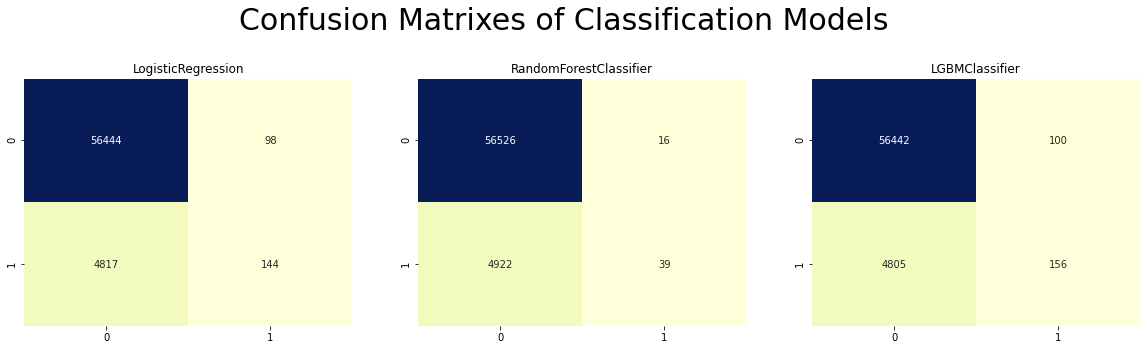

In [ ]:
plt.figure(figsize=(20,10))
plt.suptitle("Confusion Matrices of Classification Models",fontsize=30)

plt.subplot(2,3,1)
plt.title("LogisticRegression")
sns.heatmap(cm_lr,annot=True,cmap='YlGnBu',fmt=".0f",cbar=False)

plt.subplot(2,3,2)
plt.title("RandomForestClassifier")
sns.heatmap(cm_rf,annot=True,cmap='YlGnBu',fmt=".0f",cbar=False)

plt.subplot(2,3,3)
plt.title("LGBMClassifier")
sns.heatmap(cm_lgbm,annot=True,cmap='YlGnBu',fmt=".0f",cbar=False)

## Feature importances

### Logistic Regression (coefficients)

In [ ]:
importances = pd.DataFrame(
    {"feature": WORKING_train.columns, "coefficients": lr.coef_[0].tolist()}
)
importances.nlargest(10, 'coefficients')

,feature,coefficients
361,TARGET_NEIGHBORS_500_VAR,2.323885
116,CNT_PAYMENT,1.639761
157,STAT_ACTIVE,1.457773
128,SHORT_ON_PAYMENT_RATIO,1.059348
3,AMT_ANNUITY_x,1.007240
142,CNT_DRAWINGS_ATM_CURRENT,0.973112
2,AMT_CREDIT_x,0.941893
130,AMT_BALANCE,0.831593
141,AMT_TOTAL_RECEIVABLE,0.820438
140,AMT_RECIVABLE,0.820287


### RandomForestClassifier

In [ ]:
importances = pd.DataFrame(
    {"feature": WORKING_train.columns, "feature_importances": rf.feature_importances_.tolist()}
)
importances.nlargest(10, 'feature_importances')

,feature,feature_importances
356,TARGET_NEIGHBORS_500_MEAN,0.026008
361,TARGET_NEIGHBORS_500_VAR,0.024652
353,EXT_SOURCES_MEAN,0.020081
351,EXT_SOURCES_MIN,0.019307
354,EXT_SOURCES_NANMEDIAN,0.017598
352,EXT_SOURCES_MAX,0.016461
28,EXT_SOURCE_2,0.015342
6,DAYS_BIRTH,0.012923
9,DAYS_ID_PUBLISH,0.012674
8,DAYS_REGISTRATION,0.012411


### LGBMClassifier

In [ ]:
importances = pd.DataFrame(
    {"feature": WORKING_train.columns, "feature_importances": lgbm.feature_importances_.tolist()}
)
importances.nlargest(10, 'feature_importances')

,feature,feature_importances
361,TARGET_NEIGHBORS_500_VAR,113
6,DAYS_BIRTH,86
351,EXT_SOURCES_MIN,86
116,CNT_PAYMENT,78
124,LATE,62
128,SHORT_ON_PAYMENT_RATIO,58
9,DAYS_ID_PUBLISH,57
107,AMT_DOWN_PAYMENT,55
515,APPS_INCOME_EMPLOYED_RATIO,53
356,TARGET_NEIGHBORS_500_MEAN,51
